# SAD2 2022/2023 - Introduction to Variational Inference

This week we will introduce the variational inference. The concepts discussed in previous week, namely MLE, ELBO, and KL divergence come together in this framework. Variational inference embraces a family of methods for approximating complicated densities by a simpler class of densities, as introduced [here](https://www.cs.toronto.edu/~bonner/courses/2020s/csc2547/week2/variational-inference-tutorial,-mohamed,-2015.pdf).

This week we will start working with Pyro. Pyro is a dynamic object-oriented programming language created to support what we call the probabilistic programming. Pyro combines the elegance and expressiveness of Python with the performance and robustness of C++. Pyro is built on top of the PyTorch library and uses the same underlying C++ code.

This lab is heavily based on [Pyro tutorial on Stochastic Variational Inference](https://pyro.ai/examples/svi_part_i.html). It is possible to implement this exercise solely based on this tutorial, however, we want to let you know that there are more useful resources regarding Pyro (cue Project 1 ;)):

   - [Introduction to Pyro](http://pyro.ai/examples/intro_long.html)
   - [GMM in Pyro](https://pyro.ai/examples/gmm.html)
   - [SVI Part II: Conditional Independence, Subsampling, and Amortization](https://pyro.ai/examples/svi_part_ii.html)

In [362]:
import random
from collections import defaultdict

import torch
import pyro

import numpy as np
import pandas as pd

# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns


## 0. The "Variational" in "Variational Inference"

The "Variational" in "Variational Inference" is a reference to the fact that in variational inference we optimize a function, called the variational lower bound, over a set of variables known as variational parameters. The variational parameters are usually chosen to be the natural parameters of a probability distribution, which means that they can be used to define a probability distribution. The goal of variational inference is to find a set of variational parameters that makes the variational lower bound as tight as possible.

There are many different ways to formulate the variational lower bound, but the most common one is based on the Kullback-Leibler (KL) divergence. The KL divergence is a measure of the difference between two probability distributions. In the context of variational inference, we can think of the KL divergence as a measure of the difference between the true posterior distribution and the approximate posterior distribution. The goal of variational inference is to find a set of variational parameters that minimizes the KL divergence between the true posterior and the approximate posterior.

Recall the KL divergence is defined as:

$KL(p||q) = \sum_x p(x) \log \frac{p(x)}{q(x)}$

where $p$ and $q$ are two probability distributions. In the context of variational inference, $p$ is the true posterior distribution and $q$ is the approximate posterior distribution.

The variational lower bound is then defined as:

$\mathcal{L}(p, q) = \sum_x p(x) \log q(x) - KL(p||q)$

The goal of variational inference is to find a set of variational parameters that minimizes the KL divergence between the true posterior and the approximate posterior. In other words, we want to find a set of variational parameters that makes the variational lower bound as tight as possible.

There are many different ways to optimize the variational lower bound. The most common one is gradient descent. In gradient descent, we take the gradient of the variational lower bound with respect to the variational parameters and then update the variational parameters in the direction that maximizes the variational lower bound.

There are many different ways to initialize the variational parameters. The most common one is to initialize them randomly. Once the variational parameters have been optimized, we can then use them to define a probability distribution. This probability distribution is our approximate posterior distribution. We can then use this approximate posterior distribution to make predictions about the data.

There are many different ways to evaluate the quality of the approximate posterior distribution as well. The most common one is to compute the KL divergence between the true posterior and the approximate posterior. Other common evaluation metrics include the log-likelihood and the predictive accuracy.

## 1. ELBO and KL divergence in Variational Inference

ELBO (Evidence Lower Bound) is a method used in variational inference to approximate a complex posterior distribution. This method is used when the posterior distribution cannot be easily calculated. The ELBO is lower than the marginal likelihood of the data (evidence), but is often easier to optimize.

KL divergence is a measure of how different two probability distributions are. In variational inference, KL divergence is used to measure the difference between the approximate posterior distribution and the true posterior distribution.


## 2. Infer the posterior distribution of $\mu$ and $\sigma$ ($\tau$) in the example form the lecture.

## Problem statement

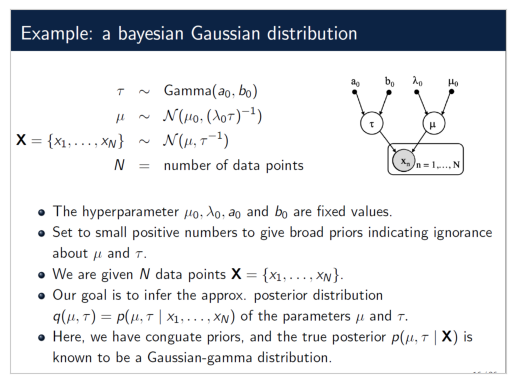

In [349]:
fig, ax = plt.subplots(1, 1)
ax.imshow(plt.imread('img.png'))

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Draw data

In [450]:
from torch.distributions import Normal

MEAN = 5.0
STD = 0.5
N_SAMPLES = 20

#smoll data
data = torch.tensor([10., 10., 10., 10., 10.])

#big data
NORMAL = Normal(torch.tensor([MEAN]), torch.tensor([STD]))
data = NORMAL.sample((N_SAMPLES,))

### Define model
See [Models in Pyro](http://pyro.ai/examples/intro_long.html#:~:text=%C2%B6-,Probabilistic,-models%20in%20Pyro)

In [630]:
import pyro.distributions as dist

def model(data):
    # define the hyperparameters that control the Gamma prior
    alpha0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)

    # define the hyperparameters that control the Normal prior
    mu0 = torch.tensor(1.0)
    lambda0 = torch.tensor(1.0)

    mean = pyro.sample("mean", dist.Normal(mu0, lambda0))
    std = pyro.sample("std", dist.Gamma(alpha0, beta0))

    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the Normal
        pyro.sample(f"obs_{i}", dist.Normal(mean, std), obs=data[i])

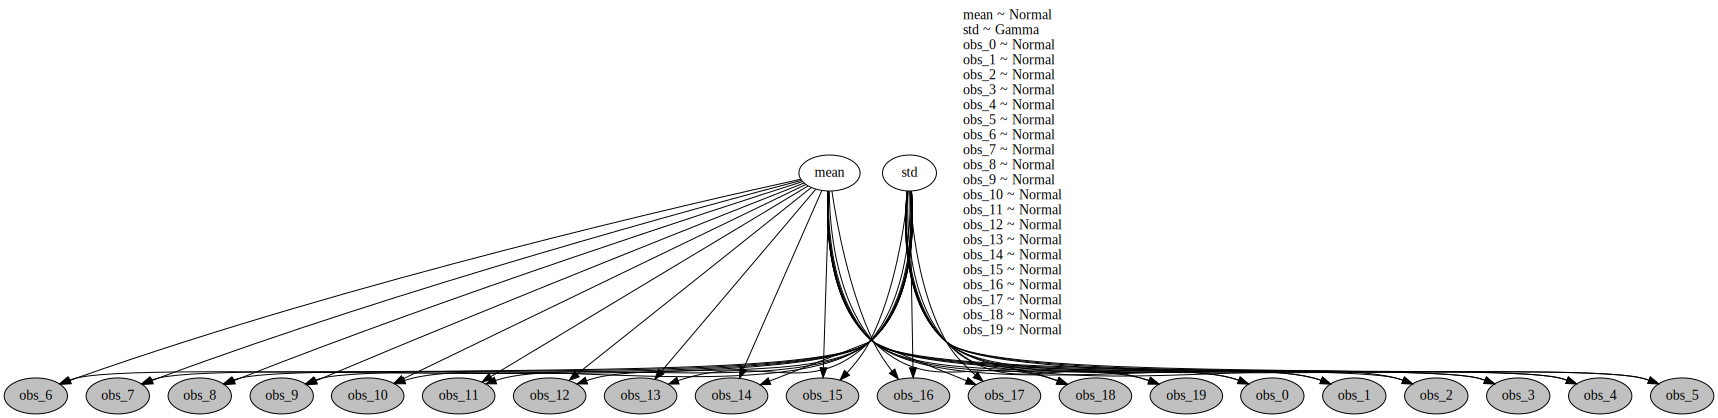

In [631]:
# sudo apt-get install graphviz
# pip install graphviz

pyro.render_model(model, model_args=(data,), render_distributions=True)

### Define guide $q_{\phi}({\bf z})$

See [Guides in Pyro](http://pyro.ai/examples/intro_long.html#:~:text=original%20KL%2Ddivergence.-,Background%3A%20%E2%80%9Cguide%E2%80%9D%20programs%20as%20flexible%20approximate%20posteriors,%C2%B6,-In%20variational%20inference)


In [632]:
import torch.distributions.constraints as constraints

def guide(data):
    # register the variational parameters with Pyro
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(1.0),
                        constraint=constraints.positive)

    mu_q = pyro.param("mu_q", torch.tensor(1.0))
    lambda_q = pyro.param("lambda_q", torch.tensor(1.0))

    # sample the distribution Normal(mu_q, lambda_q)
    # sample the distribution Gamma(alpha_q, beta_q)

    mean = pyro.sample("mean", dist.Normal(mu_q, lambda_q))
    std = pyro.sample("std", dist.Gamma(alpha_q, beta_q))

    return {"alpha_q": alpha_q, "beta_q": beta_q, "mu_q": mu_q, "lambda_q": lambda_q, "mean": mean, "std": std}

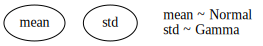

In [633]:
# pyro.render_model(guide, model_args=(data,), render_distributions=True)

### Define optimizer

Optional: do some tweaks to the optimizer and see if it changes the params and convergence.

In [634]:
from pyro.optim import Adam

adam_params = {"lr": 0.005}
optimizer = Adam(adam_params)

### Define [$SVI$ class](https://docs.pyro.ai/en/stable/inference_algos.html?highlight=svi)

In [635]:
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [636]:
n_steps = 500

# do gradient steps
for step in range(n_steps):
    svi.step(data)

In [637]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_q 30.68149
beta_q 61.556797
mu_q 4.8526745
lambda_q 0.106329516
AutoNormal.locs.mean 4.8530874
AutoNormal.scales.mean 0.031196954
AutoNormal.locs.std -0.8207596
AutoNormal.scales.std 0.050919205


In [638]:
guide(data)

{'alpha_q': tensor(30.6815, grad_fn=<AddBackward0>),
 'beta_q': tensor(61.5568, grad_fn=<AddBackward0>),
 'mu_q': tensor(4.8527, grad_fn=<AddBackward0>),
 'lambda_q': tensor(0.1063, grad_fn=<AddBackward0>),
 'mean': tensor(4.8097, grad_fn=<AddBackward0>),
 'std': tensor(0.4728, grad_fn=<DivBackward0>)}

### Plot convergence

In [639]:
def get_metrics(data, steps):
    losses = []
    means = []
    for i in range(steps):
        loss = svi.step(data)
        mean = guide(data)['mean']
        means.append(mean)
        losses.append(loss)
        print('.' if i % 100 else '\n', end='')
    return losses, means


def plot_convergence(losses, means):

    #LOSS; WHAT IS LOSS BTW?
    plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
    plt.plot(losses)
    plt.xlabel('iters')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.title('Convergence of SVI');
    plt.show()


    #MEANS
    plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
    plt.plot([tensor.detach().numpy() for tensor in means])
    plt.xlabel('iters')
    plt.ylabel('means')
    plt.title('Convergence of SVI')

    plt.show()



...................................................................................................
...................................................................................................

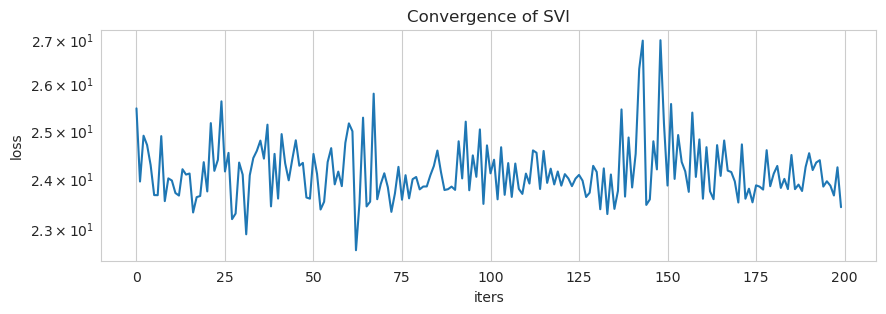

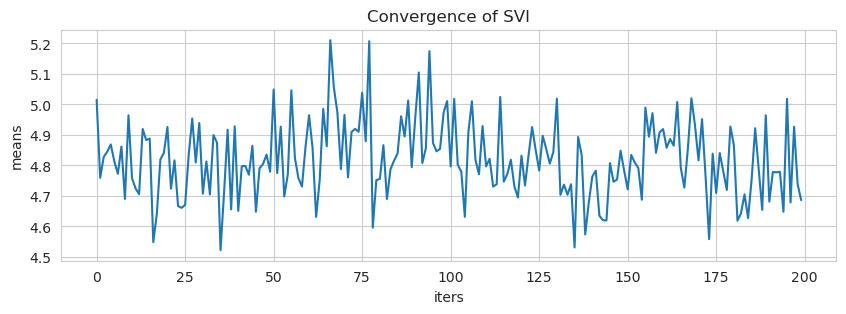

In [640]:
losses, means = get_metrics(data, 200)
plot_convergence(losses, means)


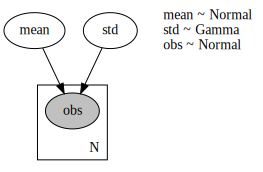

In [644]:
pyro.render_model(model, model_args=(data,), render_distributions=True)


...................................................................................................
...................................................................................................

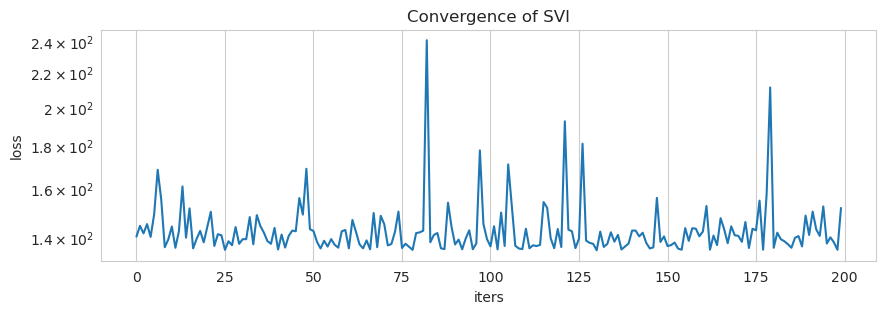

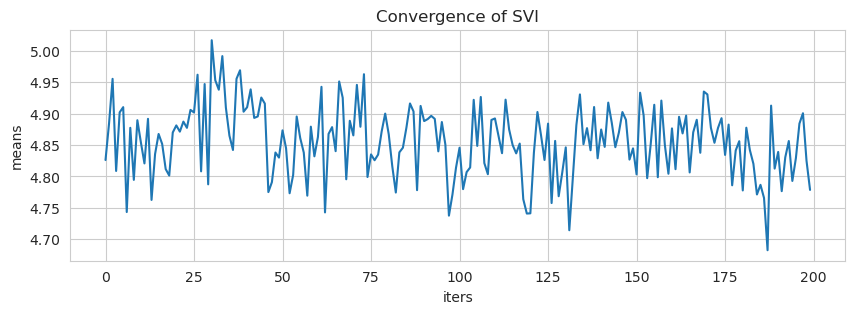

In [645]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

losses, means = get_metrics(data, 200)
plot_convergence(losses, means)
